In [0]:
from skimage import io
import os
import glob
import numpy as np
from skimage import color, exposure, transform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD,Adam
from keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
K.set_image_data_format('channels_first')


NUM_CLASSES = 43
IMG_SIZE = 48

In [0]:
def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img

In [19]:
def get_class(img_path):
    return int(img_path.split('/')[-2])

root_dir = 'train/GTSRB/Final_Training/Images/'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    label = get_class(img_path)
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
# Make one hot targets
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [0]:
model = cnn_model()

# Using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])



In [22]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 128
epochs = 20

history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('model1.h5', save_best_only=True)]
          )

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 18s 582us/step - loss: 2.7806 - acc: 0.2530 - val_loss: 1.1166 - val_acc: 0.6311
Epoch 2/20
 5760/31367 [====>.........................] - ETA: 12s - loss: 1.0991 - acc: 0.6594

31367/31367 [==============================] - 17s 530us/step - loss: 0.6816 - acc: 0.7847 - val_loss: 0.3737 - val_acc: 0.8794
Epoch 3/20
31367/31367 [==============================] - 17s 530us/step - loss: 0.2705 - acc: 0.9147 - val_loss: 0.0851 - val_acc: 0.9728
Epoch 4/20
 9984/31367 [========>.....................] - ETA: 10s - loss: 0.1830 - acc: 0.9398

31367/31367 [==============================] - 17s 537us/step - loss: 0.1683 - acc: 0.9461 - val_loss: 0.0498 - val_acc: 0.9858
Epoch 5/20
31367/31367 [==============================] - 17s 533us/step - loss: 0.1177 - acc: 0.9629 - val_loss: 0.0454 - val_acc: 0.9879
Epoch 6/20
11008/31367 [=========>....................] - ETA: 9s - loss: 0.0980 - acc: 0.9684 

31367/31367 [==============================] - 17s 533us/step - loss: 0.0939 - acc: 0.9702 - val_loss: 0.0455 - val_acc: 0.9858
Epoch 7/20
31367/31367 [==============================] - 17s 530us/step - loss: 0.0789 - acc: 0.9756 - val_loss: 0.0625 - val_acc: 0.9795
Epoch 8/20
11136/31367 [=========>....................] - ETA: 9s - loss: 0.0792 - acc: 0.9750

31367/31367 [==============================] - 17s 528us/step - loss: 0.0680 - acc: 0.9783 - val_loss: 0.0280 - val_acc: 0.9913
Epoch 9/20
31367/31367 [==============================] - 17s 530us/step - loss: 0.0543 - acc: 0.9824 - val_loss: 0.0227 - val_acc: 0.9929
Epoch 10/20
11136/31367 [=========>....................] - ETA: 10s - loss: 0.0459 - acc: 0.9862

31367/31367 [==============================] - 17s 531us/step - loss: 0.0476 - acc: 0.9847 - val_loss: 0.0237 - val_acc: 0.9931
Epoch 11/20
31367/31367 [==============================] - 17s 533us/step - loss: 0.0331 - acc: 0.9894 - val_loss: 0.0189 - val_acc: 0.9950
Epoch 12/20
11136/31367 [=========>....................] - ETA: 9s - loss: 0.0251 - acc: 0.9919

31367/31367 [==============================] - 17s 528us/step - loss: 0.0261 - acc: 0.9915 - val_loss: 0.0177 - val_acc: 0.9952
Epoch 13/20
31367/31367 [==============================] - 17s 535us/step - loss: 0.0249 - acc: 0.9921 - val_loss: 0.0169 - val_acc: 0.9954
Epoch 14/20
10880/31367 [=========>....................] - ETA: 10s - loss: 0.0215 - acc: 0.9936

31367/31367 [==============================] - 17s 534us/step - loss: 0.0227 - acc: 0.9928 - val_loss: 0.0168 - val_acc: 0.9950
Epoch 15/20
31367/31367 [==============================] - 17s 536us/step - loss: 0.0225 - acc: 0.9930 - val_loss: 0.0156 - val_acc: 0.9950
Epoch 16/20
11008/31367 [=========>....................] - ETA: 9s - loss: 0.0244 - acc: 0.9916 

31367/31367 [==============================] - 17s 533us/step - loss: 0.0227 - acc: 0.9928 - val_loss: 0.0154 - val_acc: 0.9955
Epoch 17/20
31367/31367 [==============================] - 17s 537us/step - loss: 0.0207 - acc: 0.9925 - val_loss: 0.0158 - val_acc: 0.9955
Epoch 18/20
11008/31367 [=========>....................] - ETA: 10s - loss: 0.0176 - acc: 0.9940

31367/31367 [==============================] - 17s 533us/step - loss: 0.0189 - acc: 0.9936 - val_loss: 0.0155 - val_acc: 0.9955
Epoch 19/20
31367/31367 [==============================] - 17s 533us/step - loss: 0.0191 - acc: 0.9942 - val_loss: 0.0156 - val_acc: 0.9953
Epoch 20/20
11008/31367 [=========>....................] - ETA: 10s - loss: 0.0176 - acc: 0.9947

31367/31367 [==============================] - 17s 537us/step - loss: 0.0185 - acc: 0.9940 - val_loss: 0.0162 - val_acc: 0.9950


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


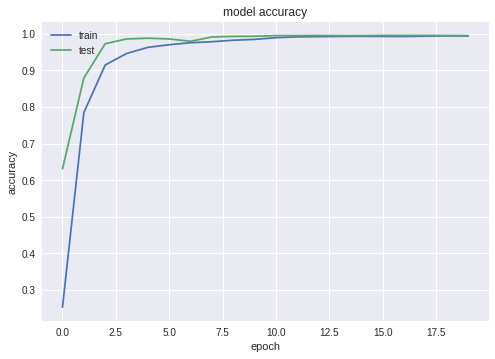

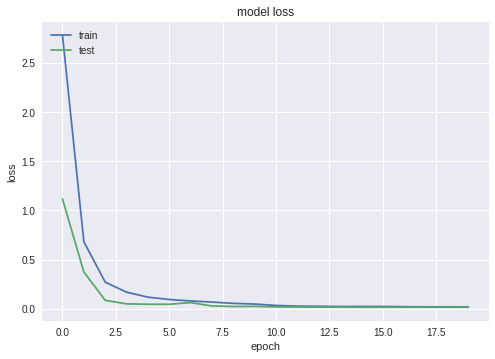

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
test = pd.read_csv('GT-final_test.csv', sep=';')

# Load test dataset
X_test = []
y_test = []
i = 0
for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('test/GTSRB/Final_Test/Images/', file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)

X_test = np.array(X_test)
y_test = np.array(y_test)

# predict and evaluate
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test) / np.size(y_pred)
print("Test accuracy = {}".format(acc))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Test accuracy = 0.9656373713380839
